In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# Parameter class

In [2]:
x = torch.rand(10,50)
w1 = nn.Parameter(torch.randn(128,50)) # creates trainable parameter

In [3]:
w1

Parameter containing:
tensor([[-0.4550, -0.3056, -1.4448,  ...,  0.0217, -1.1924,  0.7784],
        [-0.2262,  1.3214, -1.0628,  ..., -0.0284, -0.9809, -1.0959],
        [ 1.1264, -0.2783, -0.3352,  ..., -0.4920, -0.6836, -0.0463],
        ...,
        [-0.1976, -1.7936, -0.8177,  ..., -0.6384, -1.0469,  0.6647],
        [-0.0146,  0.1801,  0.5008,  ...,  0.1404, -2.9482,  0.3240],
        [-0.3672,  0.5684,  0.0064,  ..., -0.2138,  1.4483, -1.1369]],
       requires_grad=True)

In [4]:
w1.shape

torch.Size([128, 50])

In [5]:
w1.t().shape

torch.Size([50, 128])

In [6]:
y = x@w1.t()
y.shape

torch.Size([10, 128])

# Linear class

In [7]:
w2 = nn.Linear(128, 50)
w2

Linear(in_features=128, out_features=50, bias=True)

You can notice the difference between the linear and parameter class here

In [8]:
print(w1.shape)
print(w2.weight.shape)

torch.Size([128, 50])
torch.Size([50, 128])


Size of w -> [output, input], but in nn.Linear [input, output]

# Tied weights

Mirroring the wieght matrices of encoder and decoder part

In [9]:
data = pd.read_csv("/Users/veera/Data/Repos/Udemy/.dataset/mnist_train.csv", delimiter=',', header=None)
labels = data[0]
data = data.drop(columns=[0])
data = np.array(data)
labels = np.array(labels)
data = data[:10000]

In [10]:
# The min and max values of the data are 0 and 255
# It is normalized to 0 and 1
data_norm = data/np.max(data)
data_tensor = torch.tensor(data_norm).float()
label_tensor = torch.tensor(labels).long()

In [11]:
def model():
    class aenet(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(784, 128)
            self.enc = nn.Parameter(torch.randn(50, 128))
            # self.enc = nn.Linear(128, 50)
            # self.latent = nn.Linear(50, 128)
            self.dec = nn.Linear(128, 784)
        def forward(self, x):
            x = F.relu(self.input(x))
            # a parameter is not a linear type, so we need to implement the matrix multiplication
            x = x.t()
            x = F.relu(self.enc@x)
            # same for the decoding layer but reversed
            x = F.relu(self.enc.t()@x)
            x = x.t()
            y = torch.sigmoid(self.dec(x))
            # we want the output in the same range (normalized as 0 to 1 in the previous step) as the input numerical data
            return y
        
    net = aenet()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_function, optimizer

In [12]:
net, loss_function, optimizer = model()

In [13]:
sample_x = data_tensor[:5]
sample_yhat = net(sample_x)

In [14]:
sample_yhat.shape

torch.Size([5, 784])

In [15]:
def train():
    epochs = 20000
    net, loss_function, optimizer = model()
    losses = []
    for i in range(epochs):
        # select a random set of 32 image instead of using minibatch format
        randomidx = np.random.choice(data_tensor.shape[0], size=32)
        x = data_tensor[randomidx,:]
        yhat = net(x)[0]
        loss = loss_function(yhat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses, net

/Users/veera/Data/Repos/Udemy/.udemy/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 784])) that is different to the input size (torch.Size([784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


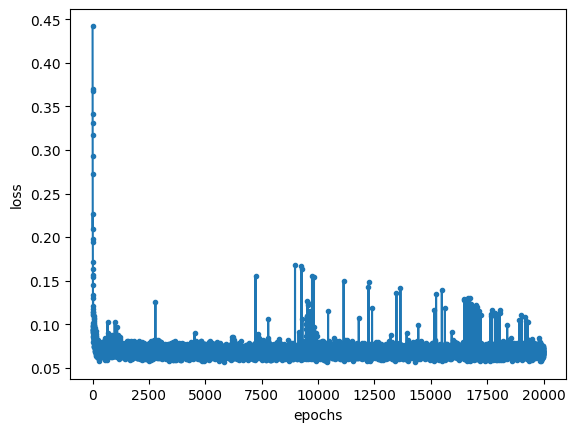

In [16]:
loss, net = train()
plt.plot(loss, '.-')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Pros and cons of tied weights

- Less parameters to train. So, low risk of overfitting. Generally comparable to non-tied weights
- Performance is poor compared to non-tied weight
- Code is error prone
- In practice it is not that much used